In [131]:
import torch
from diffusers import PaintByExamplePipeline
from transformers import SamModel, SamProcessor
from PIL import Image
import cv2
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display

### Models loading

In [61]:
torch_gen = torch.Generator(device="cuda")
torch_gen.manual_seed(2147483647)
device_sam = "cpu"

In [2]:
model_sam = SamModel.from_pretrained("facebook/sam-vit-base").to(device_sam)
processor = SamProcessor.from_pretrained("facebook/sam-vit-base")

pipe_inpaint = PaintByExamplePipeline.from_pretrained(
    "Fantasy-Studio/Paint-by-Example",
    torch_dtype=torch.float16,
)
pipe_inpaint.enable_sequential_cpu_offload()

image_encoder/model.safetensors not found


Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

You are using a model of type clip_vision_model to instantiate a model of type clip. This is not supported for all configurations of models and can yield errors.


In [3]:
original_image = Image.open("data/inpainting_example/handbag_original.jpg")
replacing_image = Image.open("data/inpainting_example/handbag_replacing.jpg")

original_image.size, replacing_image.size

((612, 483), (640, 640))

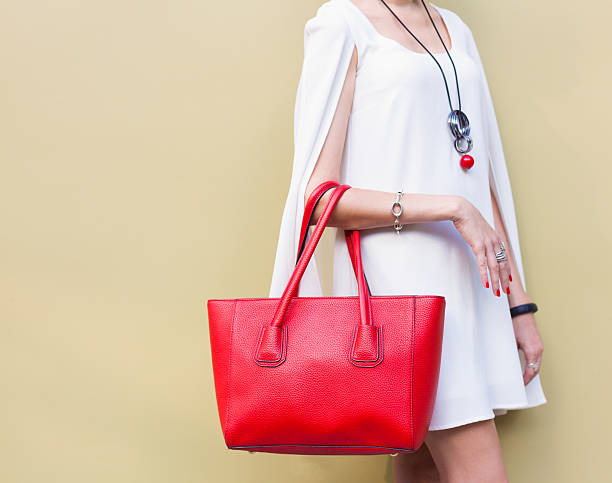

In [4]:
original_image

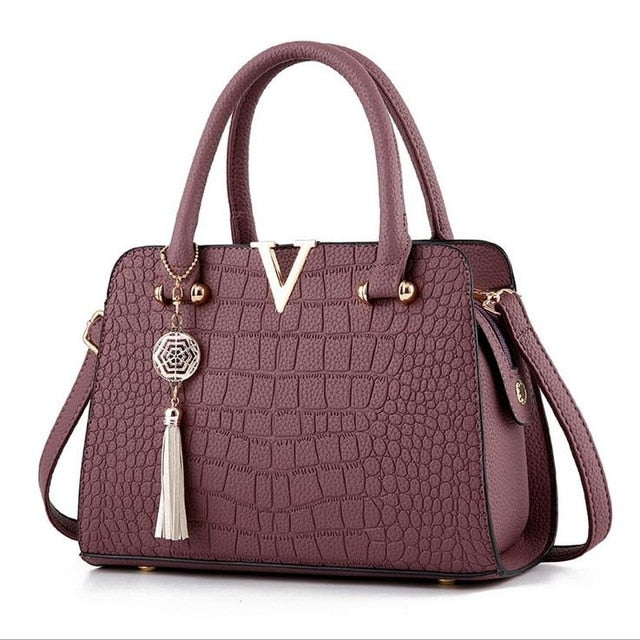

In [5]:
replacing_image

In [6]:
original_image_array = np.array(original_image)
replacing_image_array = np.array(replacing_image)

original_image_array.shape, replacing_image_array.shape

((483, 612, 3), (640, 640, 3))

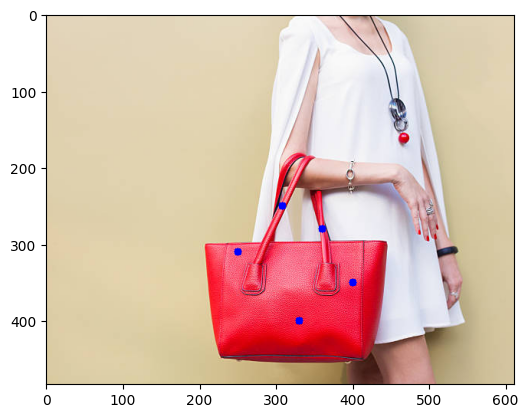

In [7]:
tmp = original_image_array.copy()
points = [
    (330, 400),
    (250, 310),
    (400, 350),
    (308, 250),
    (360, 280)
]
for p in points:
    cv2.circle(tmp, p, 5, (0,0,255), -1)
plt.imshow(tmp)
plt.show()

In [8]:
inputs_sam = processor(
    original_image,
    input_points=[points],
    return_tensors="pt",
).to(device_sam)

inputs_sam.data["pixel_values"].shape

torch.Size([1, 3, 1024, 1024])

In [9]:
%%time
outputs_sam = model_sam(**inputs_sam)

CPU times: user 24.6 s, sys: 7.84 s, total: 32.4 s
Wall time: 4.5 s


In [19]:
masks_sam = processor.image_processor.post_process_masks(
    outputs_sam.pred_masks.cpu(), inputs_sam["original_sizes"].cpu(), inputs_sam["reshaped_input_sizes"].cpu()
)

In [23]:
mask_sam_arr = masks_sam[0].squeeze().permute(1, 2, 0).numpy()
mask_sam_arr.shape

(483, 612, 3)

In [25]:
mask_values_mapping = {True: 255, False: 0}

def replace(element):
    return mask_values_mapping.get(element, element)


v_replace = np.vectorize(replace)


final_mask = v_replace(mask_sam_arr)

In [28]:
final_mask.shape, np.unique(final_mask), final_mask.dtype

((483, 612, 3), array([  0, 255]), dtype('int64'))

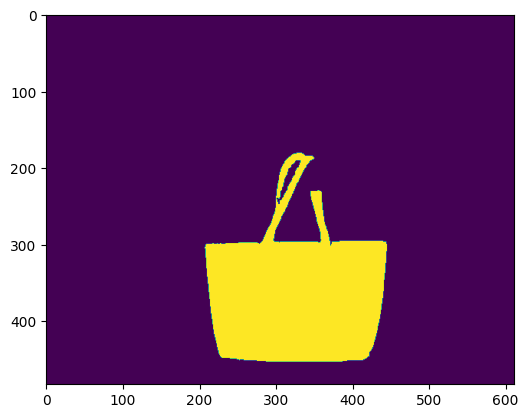

In [35]:
plt.imshow(final_mask[:, :, 1])
plt.show()

In [50]:
final_mask_extract = np.repeat(final_mask[:, :, 1][:, :, np.newaxis], 3, axis=2)
final_mask_extract.shape

(483, 612, 3)

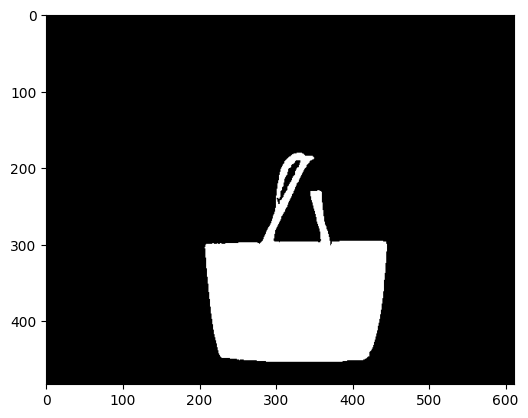

In [55]:
plt.imshow(final_mask_extract)
plt.show()

In [71]:
%%time

image = pipe_inpaint(
    image=original_image.resize((600, 480)),
    mask_image=Image.fromarray(final_mask_extract.astype(np.uint8)).resize((600, 480)),
    example_image=replacing_image,
    generator=torch_gen
)

  0%|          | 0/50 [00:00<?, ?it/s]

CPU times: user 19 s, sys: 16 s, total: 35 s
Wall time: 35.3 s


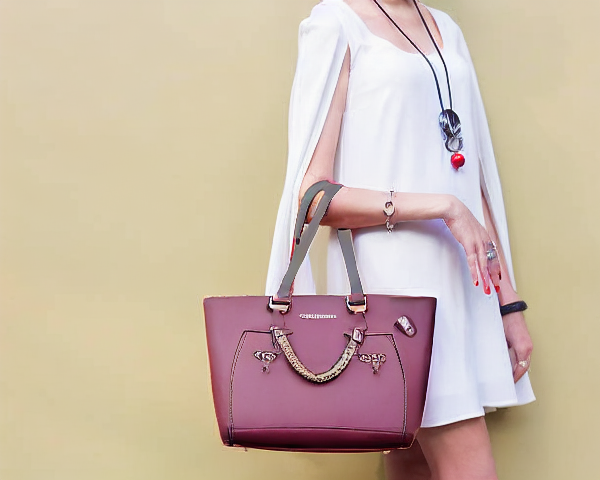

In [73]:
image.images[0]

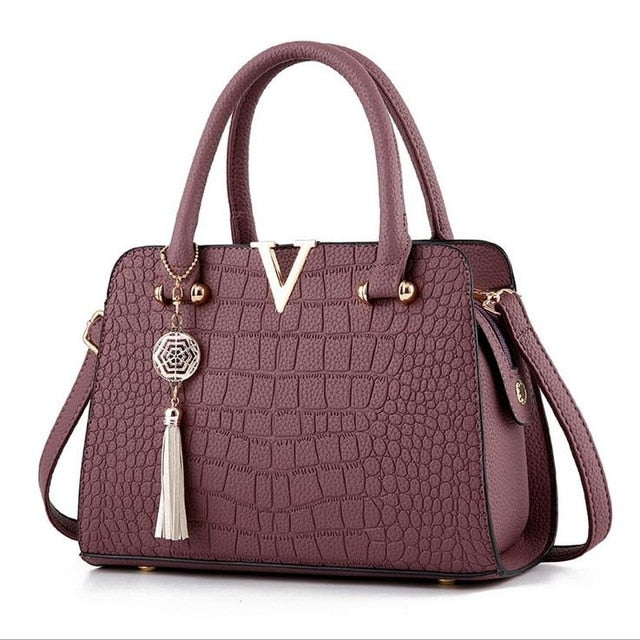

In [74]:
replacing_image

  0%|          | 0/50 [00:00<?, ?it/s]

CPU times: user 13.4 s, sys: 14.8 s, total: 28.2 s
Wall time: 28.1 s


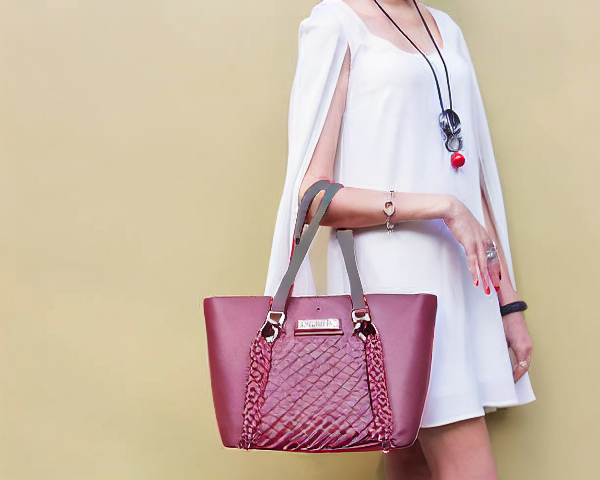

In [77]:
%%time

pipe_inpaint(
    image=original_image.resize((600, 480)),
    mask_image=Image.fromarray(final_mask_extract.astype(np.uint8)).resize((600, 480)),
    example_image=replacing_image,
    generator=torch_gen,
    negative_prompt="blurry, low quality, low resolution, sketch",
).images[0]

  0%|          | 0/50 [00:00<?, ?it/s]

CPU times: user 12.7 s, sys: 15.2 s, total: 28 s
Wall time: 27.8 s


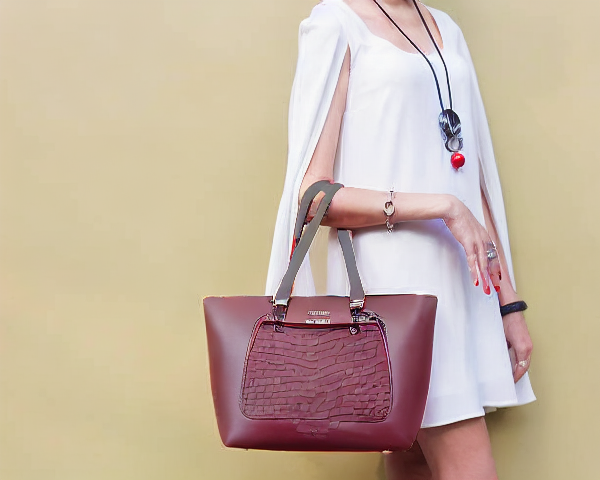

In [78]:
%%time

pipe_inpaint(
    image=original_image.resize((600, 480)),
    mask_image=Image.fromarray(final_mask_extract.astype(np.uint8)).resize((600, 480)),
    example_image=replacing_image,
    generator=torch_gen,
    negative_prompt="blurry, low quality, low resolution, sketch",
    guidance_scale=4
).images[0]

  0%|          | 0/50 [00:00<?, ?it/s]

CPU times: user 13.3 s, sys: 14.8 s, total: 28.1 s
Wall time: 28 s


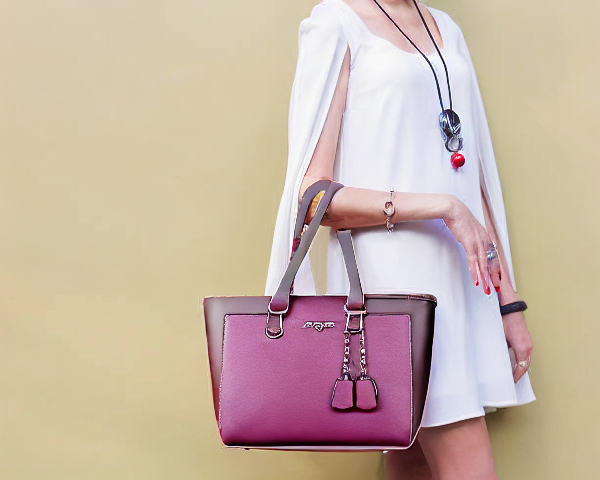

In [80]:
%%time

pipe_inpaint(
    image=original_image.resize((600, 480)),
    mask_image=Image.fromarray(final_mask_extract.astype(np.uint8)).resize((600, 480)),
    example_image=replacing_image,
    generator=torch_gen,
    negative_prompt="blurry, low quality, low resolution, sketch",
    guidance_scale=12
).images[0]

  0%|          | 0/100 [00:00<?, ?it/s]

CPU times: user 25.8 s, sys: 29.2 s, total: 54.9 s
Wall time: 54.9 s


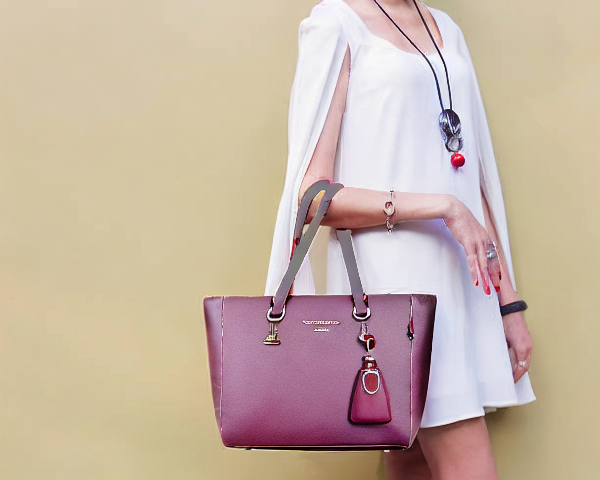

In [83]:
%%time

pipe_inpaint(
    image=original_image.resize((600, 480)),
    mask_image=Image.fromarray(final_mask_extract.astype(np.uint8)).resize((600, 480)),
    example_image=replacing_image,
    generator=torch_gen,
    negative_prompt="blurry, low quality, low resolution, sketch",
    guidance_scale=12,
    num_inference_steps=100
).images[0]

  0%|          | 0/200 [00:00<?, ?it/s]

CPU times: user 51 s, sys: 58.4 s, total: 1min 49s
Wall time: 1min 49s


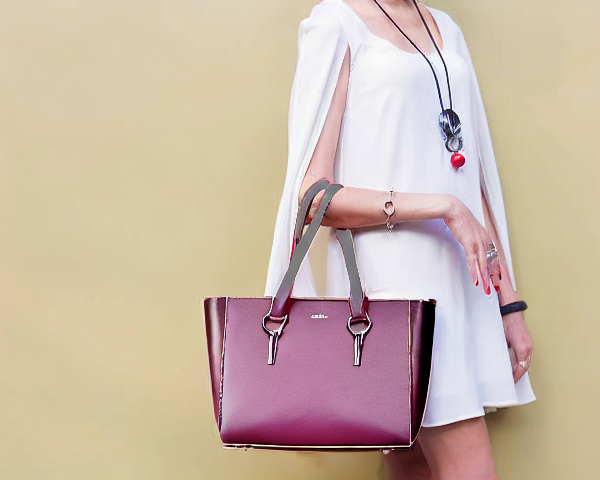

In [85]:
%%time

pipe_inpaint(
    image=original_image.resize((600, 480)),
    mask_image=Image.fromarray(final_mask_extract.astype(np.uint8)).resize((600, 480)),
    example_image=replacing_image,
    generator=torch_gen,
    negative_prompt="blurry, low quality, low resolution, sketch",
    guidance_scale=12,
    num_inference_steps=200
).images[0]

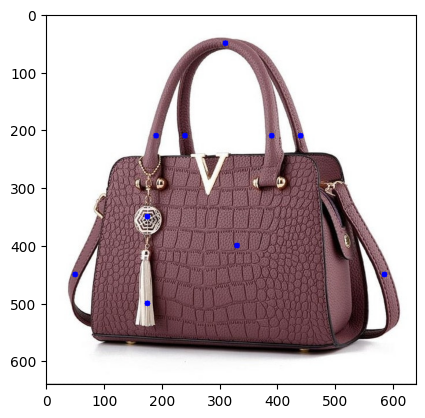

In [110]:
tmp = replacing_image_array.copy()
points2 = [
    (330, 400),
    
    (310, 50),
    (190, 210),
    (240, 210),
    (390, 210),
    (440, 210),

    (50, 450),
    (585, 450),

    (175, 350),
    (175, 500)
]
for p in points2:
    cv2.circle(tmp, p, 5, (0,0,255), -1)
plt.imshow(tmp)
plt.show()

In [111]:
%%time

inputs_sam_repl = processor(
    replacing_image,
    input_points=[points2],
    return_tensors="pt",
).to(device_sam)
outputs_sam_repl = model_sam(**inputs_sam_repl)
masks_sam_repl = processor.image_processor.post_process_masks(
    outputs_sam_repl.pred_masks.cpu(), inputs_sam_repl["original_sizes"].cpu(), inputs_sam_repl["reshaped_input_sizes"].cpu()
)
mask_sam_arr_repl = masks_sam_repl[0].squeeze().permute(1, 2, 0).numpy()

CPU times: user 26 s, sys: 9.26 s, total: 35.3 s
Wall time: 5.03 s


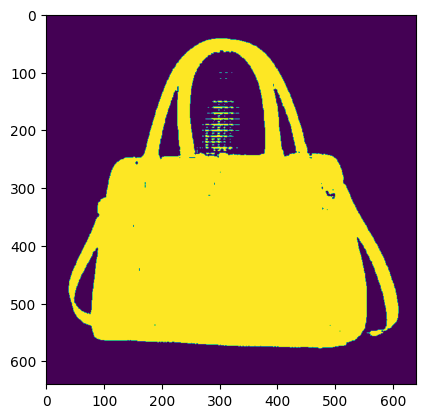

In [119]:
plt.imshow(mask_sam_arr_repl.astype(float)[:, :, 0])

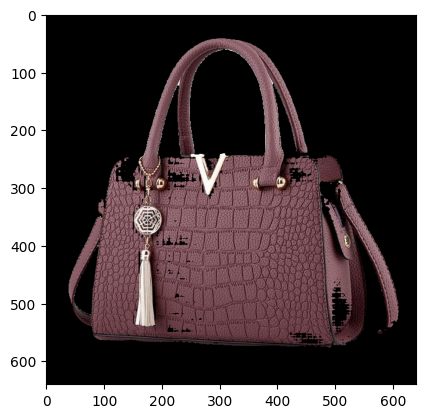

In [124]:
new_img = replacing_image_array.copy()
new_img[~mask_sam_arr_repl[:, :, 1]] = 0
plt.imshow(new_img)

  0%|          | 0/50 [00:00<?, ?it/s]

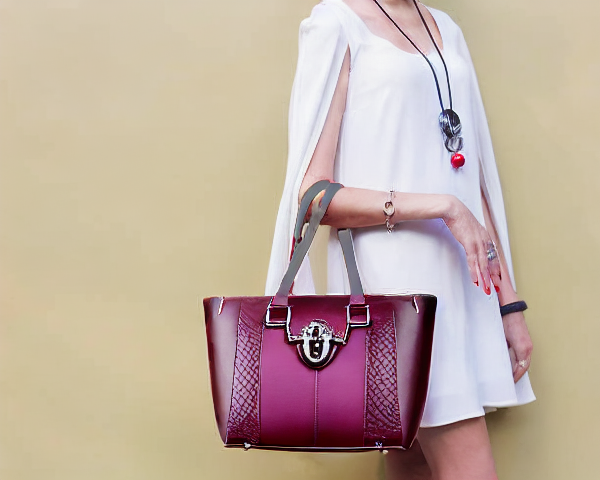

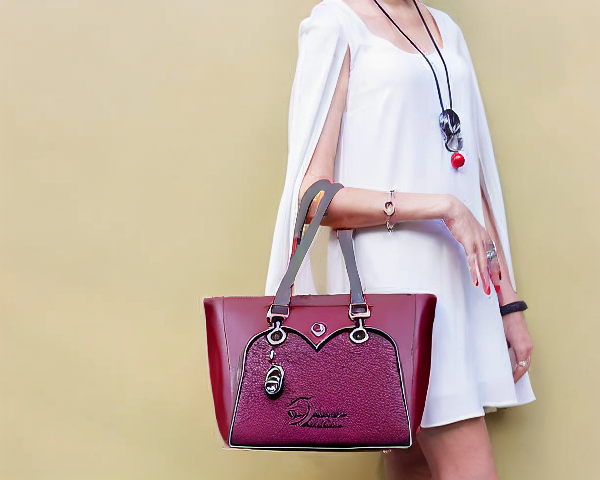

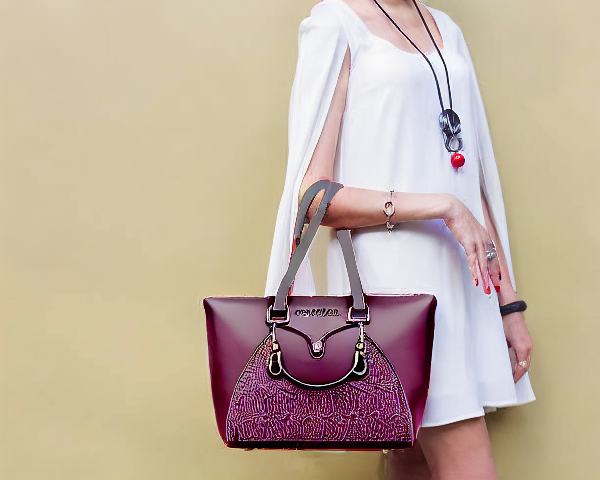

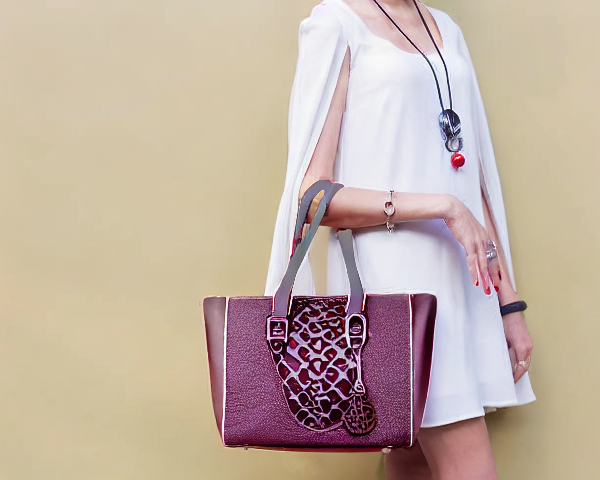

CPU times: user 15.7 s, sys: 41.1 s, total: 56.8 s
Wall time: 56.8 s


In [132]:
%%time

images = pipe_inpaint(
    image=original_image.resize((600, 480)),
    mask_image=Image.fromarray(final_mask_extract.astype(np.uint8)).resize((600, 480)),
    example_image=Image.fromarray(new_img),
    generator=torch_gen,
    negative_prompt="blurry, low quality, low resolution, sketch",
    num_images_per_prompt=4,
    guidance_scale=10
).images

for im in images:
    display(im)

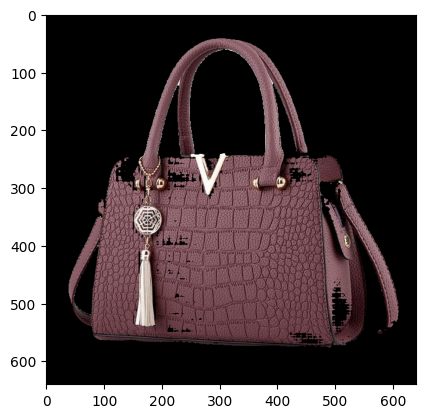

In [130]:
plt.imshow(new_img)

  0%|          | 0/50 [00:00<?, ?it/s]

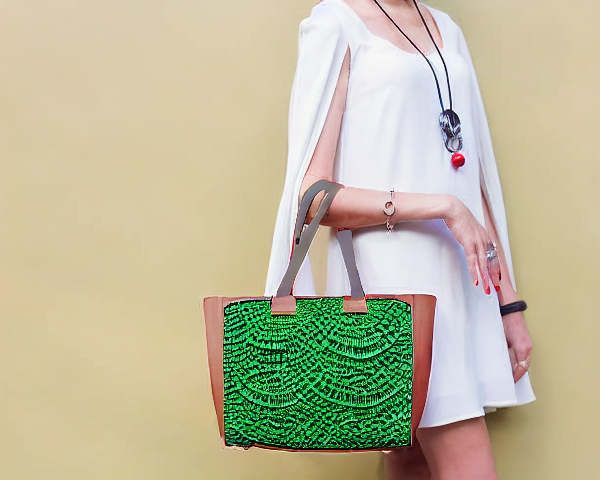

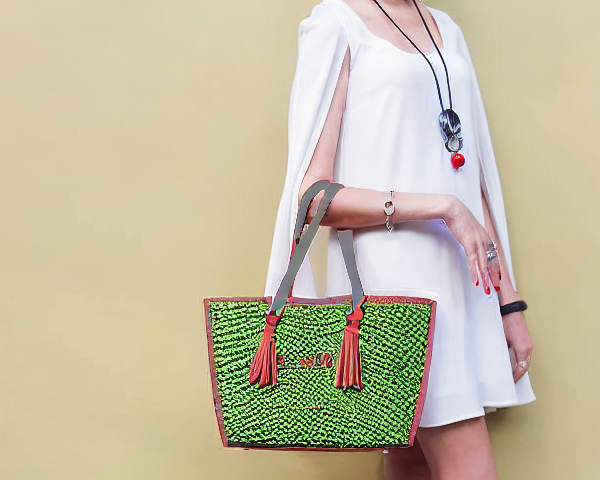

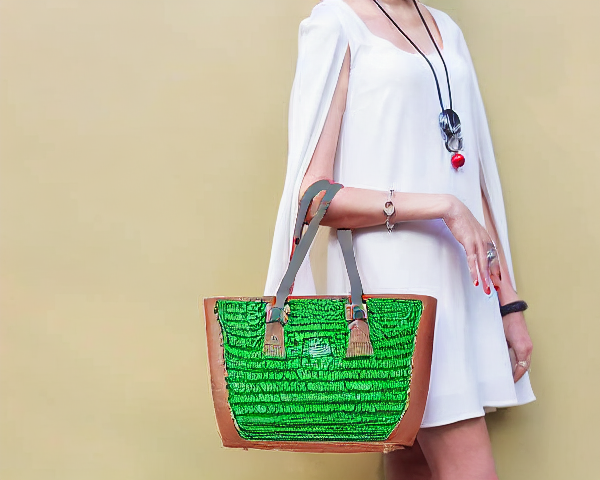

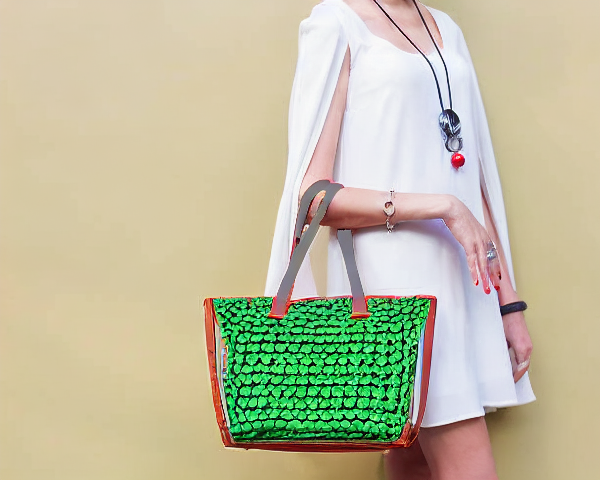

CPU times: user 15.8 s, sys: 40.8 s, total: 56.5 s
Wall time: 56.5 s


In [137]:
%%time

images = pipe_inpaint(
    image=original_image.resize((600, 480)),
    mask_image=Image.fromarray(final_mask_extract.astype(np.uint8)).resize((600, 480)),
    example_image=Image.open("data/inpainting_example/handbag_replacing2.jpg"),
    generator=torch_gen,
    negative_prompt="blurry, low quality, low resolution, sketch",
    num_images_per_prompt=4,
).images

for im in images:
    display(im)

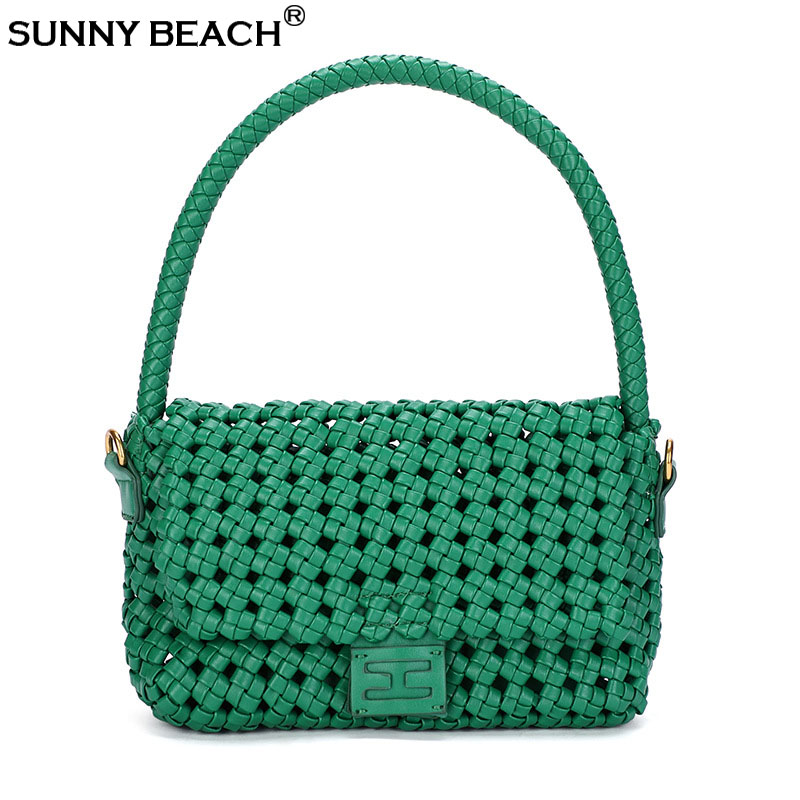

In [136]:
Image.open("data/inpainting_example/handbag_replacing2.jpg")